<a href="https://colab.research.google.com/github/XiaxiaXu/Predict-Machine-Failure-Using-Sensor-Data/blob/main/CaseStudy_Sensors_FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case study: Using sensor data to predict the machine failure in advance 
# Build the final model

In this notebook, I made a clean notebook dedicated to building the final model.

Cheers!

Xiaxia, 17.10.2021

---


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a>Import the libraries and get the Data</a></li>
        <li><a>Label alarm states</a></li>
        <li><a>Seperate test, train, validaiton dataset</a></li>
        <li><a>Preprocessing data</a></li>
        <li><a>Segmentation</a></li>
        <li><a>LSTM model</a></li>
        <li><a>Conclusions</a></li>
        <li><a>References</a></li>
</div>


# 1. Import the libraries and get the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load the data
df=pd.read_csv('/content/drive/MyDrive/CaseStudy_SensorData/pump_sensor.csv',index_col='timestamp',parse_dates=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop(['sensor_15','sensor_50'],axis=1,inplace=True)
df.replace({'BROKEN': 1, 'NORMAL': 0,'RECOVERING':0.5}, inplace=True)

# fill na, a linear interpolation from left
df=df.interpolate(method='linear',limit_direction='backward',axis=0)
Df=df.copy() # for later use

# 2. Label alarm states


In [ ]:
def add_alarm_column(df, Failure_times,timewindow_for_prediction):

  """
  Add one 'alarm' column to label the 'alarm windows'.
  value=2, 10h-5min ahead of the machine failure; 
  """
  df['alarm']=df['machine_status']
  for i,failure_time in enumerate(Failure_times):
    start_predic_time=failure_time-pd.Timedelta(seconds=60*timewindow_for_prediction[0]) #  mins before the failure time
    stop_predic_time=failure_time-pd.Timedelta(seconds=60*timewindow_for_prediction[1]) #  mins before the failure time
    df.loc[start_predic_time:stop_predic_time,'alarm']=2 # can not use 1, because 1 indicate the machine failure time
  return df

In [ ]:
Failure_times=df[df['machine_status']==1].index
df=add_alarm_column(df, Failure_times,(12*60,1)) # 12h-1min ahead of failure is the alarm windows

# 3. Seperate test, train,validaiton dataset

In [ ]:
def generate_train_validation_test_datasets(df,Failure_times):
  '''
  - the data before the first failure is used as test dataset
  - the data before the second failure is used as validation dataset
  - the data after the second failure is used as training dataset
  '''

  df_val=df.loc[:(Failure_times[0]+pd.Timedelta(seconds=60*120)),:]
  df_test=df.loc[(Failure_times[0]+pd.Timedelta(seconds=60*120)):(Failure_times[1]+pd.Timedelta(seconds=60*120)),:]
  df_train=df.loc[Failure_times[1]+pd.Timedelta(seconds=60*120):,:]

  return df_train, df_val,df_test


In [ ]:
Failure_times=df[df['machine_status']==1].index
df_train, df_val,df_test=generate_train_validation_test_datasets(df,Failure_times)
Df_train=df_train.copy()
Df_val=df_val.copy()
Df_test=df_test.copy()

# 4. Preprocessing data

## 4.1 Standardization and PCA for traing dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

sensor_names=Df_train.columns[:-2]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(Df_train[sensor_names]) # use this scaler for test and validation data set

train_scaled=scaler.transform(Df_train[sensor_names])
pca=PCA(n_components=8).fit(train_scaled) # use this pca for test and validation data set
df_train_pca=pd.DataFrame(pca.transform(train_scaled))

pcs = ['pc'+str(i+1) for i in range(8)]
df_train_pca.columns = pcs
df_train_pca['machine_status']=Df_train['machine_status'].values
df_train_pca['alarm']=Df_train['alarm'].values
df_train_pca.index=Df_train.index
df_train=df_train_pca[['pc1','pc2','pc3','pc4','machine_status','alarm']]

## 4.2 Standardization and PCA for test dataset

In [ ]:
sensor_names=Df_test.columns[:-2]
test_scaled=scaler.transform(Df_test[sensor_names])
df_test_pca=pd.DataFrame(pca.transform(test_scaled))

pcs = ['pc'+str(i+1) for i in range(8)]
df_test_pca.columns = pcs
df_test_pca['machine_status']=Df_test['machine_status'].values
df_test_pca['alarm']=Df_test['alarm'].values
df_test_pca.index=Df_test.index
df_test=df_test_pca[['pc1','pc2','pc3','pc4','machine_status','alarm']]

## 4.3 Standardization and PCA for validation dataset

In [ ]:
sensor_names=Df_val.columns[:-2]
val_scaled=scaler.transform(Df_val[sensor_names])
df_val_pca=pd.DataFrame(pca.transform(val_scaled))

pcs = ['pc'+str(i+1) for i in range(8)]
df_val_pca.columns = pcs
df_val_pca['machine_status']=Df_val['machine_status'].values
df_val_pca['alarm']=Df_val['alarm'].values
df_val_pca.index=Df_val.index
df_val=df_val_pca[['pc1','pc2','pc3','pc4','machine_status','alarm']]

# 5. Segmentation
## 5.1 Training samples

In [ ]:
def generate_seq_preFailure2(df,Failure_times,features_columns,timewindow_for_use, window_len, stride):
  '''
  Generate data samples using the time windows ahead of each machine failure time;
  window_len: how many data points from each feature will be used to make one sample for the model. 
  stride: sliding window size
  '''
  X = np.empty((1,1,window_len*len(features_columns)), float)
  Y=np.empty((1), float)

  for i,failure_time in enumerate(Failure_times):
    windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0]) #  mins before the failure time
    windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1]) #  mins before the failure time

    df_prefailure_single_window_feature=df.loc[windows_start:windows_end,features_columns]
    df_prefailure_single_window_target=df.loc[windows_start:windows_end,'alarm']
    
    data=df_prefailure_single_window_feature.to_numpy().tolist()
    targets=df_prefailure_single_window_target.tolist()

    data_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, window_len,stride=stride,sampling_rate=1,batch_size=1,shuffle=True)

    for i in range(len(data_gen)):
      x, y = data_gen[i]
      x=np.transpose(x).flatten()
      x=x.reshape((1,1,len(x)))
      X=np.append(X,x,axis=0)
      Y=np.append(Y,y/2,axis=0) # alarm windows are marked as 2, however, for the model, I will use 1 becasue of the sigmoid function. 

    # for alarm windown, no stride=1
    windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[2]) #  mins before the failure time
    windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[3]) #  mins before the failure time

    df_prefailure_single_window_feature=df.loc[windows_start:windows_end,features_columns]
    df_prefailure_single_window_target=df.loc[windows_start:windows_end,'alarm']
    
    data=df_prefailure_single_window_feature.to_numpy().tolist()
    targets=df_prefailure_single_window_target.tolist()

    data_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, window_len,stride=1,sampling_rate=1,batch_size=1,shuffle=True)

    for i in range(len(data_gen)):
      x, y = data_gen[i]
      x=np.transpose(x).flatten()
      x=x.reshape((1,1,len(x)))
      X=np.append(X,x,axis=0)
      Y=np.append(Y,y/2,axis=0) # alarm windows are marked as 2, however, for the model, I will use 1 becasue of the sigmoid function. 


  return X,Y

In [ ]:
Failure_times=df_train[df_train['machine_status']==1].index 
features_columns=df_train.columns.tolist()[:-2]
timewindow_for_use=(96*60,12*60,12*60, 5) 
window_len=20 
stride=5 
X,y=generate_seq_preFailure2(df_train,Failure_times,features_columns,timewindow_for_use,window_len, stride)

# remove the sample with Y=nan
id_keep= np.where((y == 0) | (y ==1))
y_train=y[id_keep]
X_train=X[id_keep][:,:]

print(X_train.shape, y_train.shape)

# positive cases
print('Training datasets, Alarm samples:',np.sum(y_train==1)/(np.sum(y_train==0)+np.sum(y_train==1)))  

(8279, 1, 80) (8279,)
Training datasets, Alarm samples: 0.4203406208479285


## 5.2 Test samples

In [ ]:
# Generate test dataset
def generate_seq_single_preFailure(df,failure_time,features_columns,timewindow_for_use,window_len,stride):
  '''
  Generate the test data set using one machine failure time.
  '''
  
  X = np.empty((1,1,window_len*len(features_columns)), float)
  Y=np.empty((1), float)
  
  windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0]) #  mins before the failure time
  windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1]) #  mins before the failure time
  df_prefailure_single_window_feature=df.loc[windows_start:windows_end,features_columns]
  df_prefailure_single_window_target=df.loc[windows_start:windows_end,'alarm']
    
  data=df_prefailure_single_window_feature.to_numpy().tolist()
  targets=df_prefailure_single_window_target.tolist()

  data_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, window_len,stride=stride,sampling_rate=1,batch_size=1,shuffle=False) # for ploting, do not shuffle the data
  
  for i in range(len(data_gen)):
    x, y = data_gen[i]
    x=np.transpose(x).flatten()
    x=x.reshape((1,1,len(x)))
    X=np.append(X,x,axis=0)
    Y=np.append(Y,y/2,axis=0)

  return X,Y


In [ ]:
failure_time=df_test[df_test['machine_status']==1].index[0]
print('Test failure time:',failure_time)
features_columns=df_test.columns.tolist()[:-2]
timewindow_for_use=(60*60,5) # 6h-5min
window_len=20
stride=1
X_test,y_test=generate_seq_single_preFailure(df_test,failure_time,features_columns,timewindow_for_use,window_len,stride)

# select
id_keep= np.where((y_test == 0) | (y_test ==1))
y_test=y_test[id_keep]
X_test=X_test[id_keep][:,:]
print('Test, number of positive samples', np.sum(y_test==1))
X_test.shape, y_test.shape

Test failure time: 2018-04-18 00:30:00
Test, number of positive samples 716


((3576, 1, 80), (3576,))

## 5.3 Validation samples


In [ ]:
failure_time=df_val[df_val['machine_status']==1].index[0]
print('Validation failure time:',failure_time)
features_columns=df_val.columns.tolist()[:-2]
timewindow_for_use=(60*60,5) # 6h-5min
window_len=20
stride=1
X_val,y_val=generate_seq_single_preFailure(df_val,failure_time,features_columns,timewindow_for_use,window_len,stride)

# select
id_keep= np.where((y_val == 0) | (y_val ==1))
y_val=y_val[id_keep]
X_val=X_val[id_keep][:,:]
print('Validation, number of positive samples', np.sum(y_val==1))
X_val.shape, y_val.shape

Validation failure time: 2018-04-12 21:55:00
Validation, number of positive samples 716


((3576, 1, 80), (3576,))

# 6. LSTM model
## 6.1 Build model

Hyperparameters:
* 3 layers of LSTM.
* 128, 128, 64 units in each LSTM layer.
* Slope for Leaky ReLU is set at 0.2. Leaky ReLU is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. It allows a small gradient when the unit is not active.
* A dropout rate = 0.5 is set to avoid overfiting.

* Activation funciton of the output layer is set to 'sigmoid' becasue of the binary classification problem. 


Epoch 1/50
130/130 [==============================] - 7s 11ms/step - loss: 0.5181 - binary_accuracy: 0.6939
Epoch 2/50
130/130 [==============================] - 2s 13ms/step - loss: 0.4124 - binary_accuracy: 0.7842
Epoch 3/50
130/130 [==============================] - 2s 12ms/step - loss: 0.3689 - binary_accuracy: 0.7996
Epoch 4/50
130/130 [==============================] - 2s 13ms/step - loss: 0.3391 - binary_accuracy: 0.8239
Epoch 5/50
130/130 [==============================] - 2s 12ms/step - loss: 0.3103 - binary_accuracy: 0.8464
Epoch 6/50
130/130 [==============================] - 2s 13ms/step - loss: 0.2857 - binary_accuracy: 0.8686
Epoch 7/50
130/130 [==============================] - 2s 13ms/step - loss: 0.2859 - binary_accuracy: 0.8651
Epoch 8/50
130/130 [==============================] - 2s 12ms/step - loss: 0.2713 - binary_accuracy: 0.8716
Epoch 9/50
130/130 [==============================] - 1s 12ms/step - loss: 0.2574 - binary_accuracy: 0.8790
Epoch 10/50
130/130 [=======

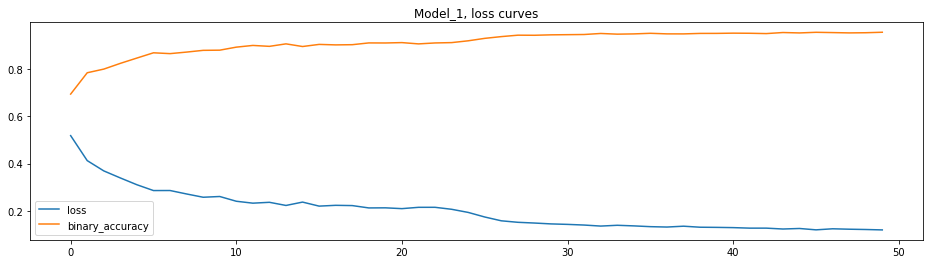

In [ ]:
# 4 LSTM layers, with 128, 128, 64,64 units in each layer
from numpy.random import seed
seed(1)

tf.random.set_seed(2)

model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model_1.add(tf.keras.layers.LeakyReLU(alpha=0.2)) # 

model_1.add(tf.keras.layers.LSTM(128,return_sequences=True))
model_1.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model_1.add(tf.keras.layers.Dropout(0.5))

model_1.add(tf.keras.layers.LSTM(64,return_sequences=True))
model_1.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model_1.add(tf.keras.layers.Dropout(0.5)) # to prevent overfiting

model_1.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',
       optimizer=tf.keras.optimizers.Adam(lr=0.01), # tried 0.1, 0.01, 0.001, 0.01 gives the best results
       metrics=['binary_accuracy']
       )

# create a learning rate callback, reduce the lr during the training
def scheduler(epoch, lr):
  if epoch < 25:
    return lr
  else:
    return 0.001

lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)

#model.summary()

history_1=model_1.fit(X_train, y_train, epochs=50, callbacks=[lr_scheduler],batch_size=64, verbose=1, shuffle=True) # real-time prediction, batchsize=1? Here for faster training, I use 64

# plot the loss (or training) curves
pd.DataFrame(history_1.history).iloc[:,:2].plot(figsize=(16,4));
plt.title('Model_1, loss curves');

## 6.2 Evaluate the model on validation samples
### 6.2.1 Confusion matrix


In [ ]:
def plot_confusion_matrix(y_test,y_test_preds,flag_model):
  # creat confusion matrics
  cm=confusion_matrix(y_test,tf.round(y_test_preds))
  cm_norm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis] # normalize the confusion matrics
  n_classes=cm.shape[0]

  fig,ax=plt.subplots(figsize=(5,5))
  cax=ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # create classes
  classes=False
  if classes:
    labels=classes
  else:
    labels=np.arange(cm.shape[0])

  # label the axes
  ax.set(title=flag_model,
      xlabel='Predicted label',
      ylabel='True label',
      xticks=np.arange(n_classes),
      yticks=np.arange(n_classes),
      xticklabels=labels,
      yticklabels=labels)

  # set x-axis labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  # adjust label size
  ax.yaxis.label.set_size(20)
  ax.title.set_size(20)
  ax.xaxis.label.set_size(20)

  # set threshold for different colors
  threshold=(cm.max()+cm.min())/2.

  # plot the text on each cell
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,f"{cm[i,j]}({cm_norm[i,j]*100:.1f}%)",
        horizontalalignment='center',
        color='white' if cm[i,j]>threshold else 'black',
        size=15)
    
from sklearn.metrics import confusion_matrix
import itertools

112/112 [==============================] - 1s 3ms/step - loss: 0.9319 - binary_accuracy: 0.8289
Model loss on the validation set: 0.9319
Model accuracy on the validation set: 82.89%
Model recall on the validation set: 0.3017
Model precison on the validation set: 0.9608


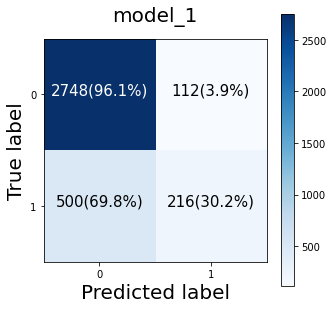

In [ ]:
# evaluation1: loss and accuracy
loss,accuracy=model_1.evaluate(X_val,y_val)
print(f'Model loss on the validation set: {loss:.4f}')
print(f'Model accuracy on the validation set: {(accuracy*100):.2f}%')

# evaluation2: recall
y_val_preds_1=model_1.predict(X_val).flatten()
y_val_preds_1=tf.round(y_val_preds_1)
cm=confusion_matrix(y_val,tf.round(y_val_preds_1))
recall=(cm[1,1])/(cm[1,1]+cm[1,0])
precision=(cm[0,0])/(cm[0,1]+cm[0,0])
print(f'Model recall on the validation set: {recall:.4f}') 
print(f'Model precison on the validation set: {precision:.4f}') 

# evaluation3: confusion matrix
plot_confusion_matrix(y_val,y_val_preds_1,'model_1')

### 6.2.2 Visualize the results

failure time: 2018-04-12 21:55:00


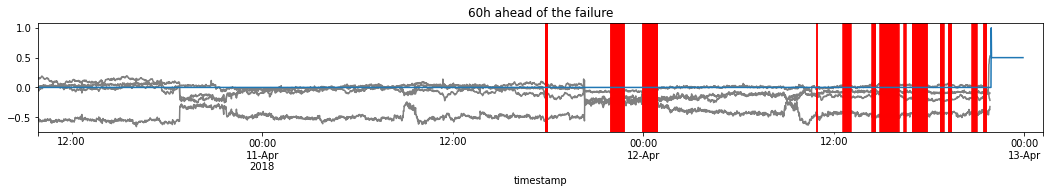

In [ ]:
failure_time=df_val[df_val['machine_status']==1].index[0]
print('failure time:',failure_time)
windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0])
windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1])
df_preFailure=df_val.loc[windows_start:windows_end,:]

y_val_preds_1=model_1.predict(X_val).flatten()
y_val_preds_1=tf.round(y_val_preds_1)
df_preFailure['alarm']=np.append(np.zeros(window_len),(y_val_preds_1))

df_preFailure[['pc1','pc2','pc3','pc4']].plot(c="grey",figsize=(18,2),legend=None)
df_preFailure[df_preFailure['alarm']==1].index.to_list()

# vertical lines
for xc in df_preFailure[df_preFailure['alarm']==1].index.to_list():
  plt.axvline(x=xc,c='red')

df_val['machine_status'].plot()
plt.xlim([windows_start,windows_end+pd.Timedelta(seconds=60*200)])

plt.title("60h ahead of the failure")
plt.show()

## 6.3 Evaluation on the test samples

### 6.3.1 Confusion matrix

112/112 [==============================] - 0s 3ms/step - loss: 1.3467 - binary_accuracy: 0.8674
Model loss on the test set: 1.3467
Model accuracy on the test set: 86.74%
Model recall on the test set: 0.3966
Model precison on the test set: 0.9853


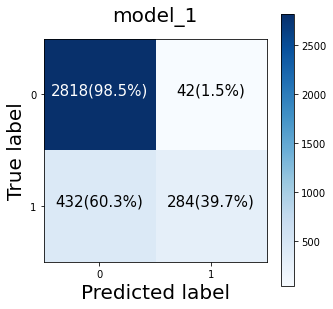

In [ ]:
# evaluation1: loss and accuracy
loss,accuracy=model_1.evaluate(X_test,y_test)
print(f'Model loss on the test set: {loss:.4f}')
print(f'Model accuracy on the test set: {(accuracy*100):.2f}%')

# evaluation2: recall
y_test_preds_1=model_1.predict(X_test).flatten()
y_test_preds_1=y_test_preds_1.flatten()
y_test_preds_1=tf.round(y_test_preds_1)
cm=confusion_matrix(y_test,tf.round(y_test_preds_1))
recall=(cm[1,1])/(cm[1,1]+cm[1,0])
precision=(cm[0,0])/(cm[0,1]+cm[0,0])
print(f'Model recall on the test set: {recall:.4f}') 
print(f'Model precison on the test set: {precision:.4f}') 

# evaluation3: confusion matrix

plot_confusion_matrix(y_test,y_test_preds_1,'model_1')

### 6.3.2 Visualize the results

failure time: 2018-04-18 00:30:00


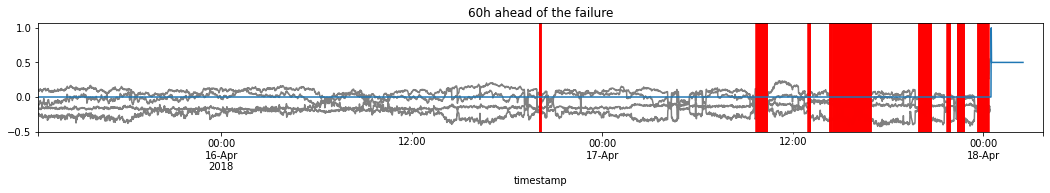

In [ ]:
failure_time=df_test[df_test['machine_status']==1].index[0]
print('failure time:',failure_time)
windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0])
windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1])
df_preFailure=df_test.loc[windows_start:windows_end,:]

y_test_preds_1=model_1.predict(X_test).flatten()
y_test_preds_1=tf.round(y_test_preds_1)
df_preFailure['alarm']=np.append(np.zeros(window_len),(y_test_preds_1))

df_preFailure[['pc1','pc2','pc3','pc4']].plot(c="grey",figsize=(18,2),legend=None)
df_preFailure[df_preFailure['alarm']==1].index.to_list()

# vertical lines
for xc in df_preFailure[df_preFailure['alarm']==1].index.to_list():
  plt.axvline(x=xc,c='red')

df_test['machine_status'].plot()
plt.xlim([windows_start,windows_end+pd.Timedelta(seconds=60*200)])

plt.title("60h ahead of the failure")
plt.show()


From the results, we can see that:
* The false positive rate (1.5%) is quite low, which means our model will not give too many false alarms;
* In the time time window of 12h before the failure, our model will give 284 alarms, which is enough to notify the engineers to check if there is a problem.







## 6.3.3 Make animation to mimic the prediction in real

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc 
rc('animation', html='html5') # equivalent to rcParams['animation.html'] = 'html5'

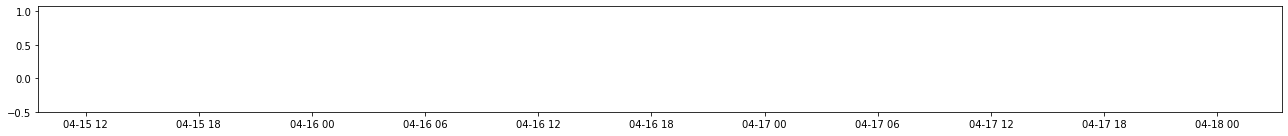

In [ ]:
def animate(i):
  x=df_preFailure.index[:i*100]
  y1=df_preFailure["pc1"][:i*100]
  y2=df_preFailure["pc2"][:i*100]
  y3=df_preFailure["pc3"][:i*100]
  y4=df_preFailure["pc4"][:i*100]
  machine_status=df_preFailure['machine_status'][:i*100]
  alarm=df_preFailure['alarm'][:i*100]
  
  plt.cla()
  plt.plot(x,y1,c="grey")
  plt.plot(x,y2,c="grey")
  plt.plot(x,y3,c="grey")
  plt.plot(x,y4,c="grey")
  #plt.plot(x,machine_status,label='machine state')
  plt.plot(x,alarm,label='alarm',c="red")
  plt.tight_layout()

plt.figure(figsize=(18,2))
ani=FuncAnimation(plt.gcf(),animate,interval=1000,frames=40, repeat=True)
ani

# 7. Conclusions

The results confirm that the LSTM model is suitable for early detection of machine failures (12h-5min before failure). Based on the performance of the model on the test data, I suggest that in real production, if the model issues an alarm, then the engineer can wait to see if more alarms will come. If no more alarms appear, then the engineers do not need to do anything. But if more alarms come, then the engineers need to check whether there is a problem.

However, considering that I first used PCA to reduce the dimension of all sensor input, even if one of the sensors failed, the model would not work. Given that many sensors are highly correlated, one of the possibilities for optimizing the model may be
* group sensors into several groups based on the correlation between each other and the domain knowledge of the sensor data. 
* select one sensor from each group to train the model. 

By doing so, in real production, if one sensor used in the model breaks down, we can choose a second one from its group to do the prediction. 


# 8. References
* Jason Brownlee, [How to Get Started with Deep Learning for Time Series Forecasting (7-Day Mini-Course)](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/). 
* Jason Brownlee, [How to Develop LSTM Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/). 
* Alexandra Amidon, [A Brief Survey of Time Series Classification Algorithms](https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97).
* Pedro Lara-Benítez, [An Experimental Review on Deep Learning Architectures for Time Series Forecasting](https://arxiv.org/abs/2103.12057).
* Tarang Shah, [About Train, Validation and Test Sets in Machine Learning](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7).
* Jason Brownlee, [How to Get Reproducible Results with Keras](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/).

# Thank you very much for checking the code, and suggestions are welcome!